# Analysis of New York Motor Vehicle Collisions
### UCDPA Project, Hauke Laing

## Setup

In [ ]:
# import required libraries
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Collection

### helper functions

In [ ]:
def read_api_chunk(api, limit=1000, offset=0):
    """read a single chunk from the api"""
    return pd.read_json(f"{api}?${limit=}&${offset=}")


def read_api(api, total_size, chunk_size=1000):
    """read given number of lines from api, applying the chunk_size along the way"""
    # use https://docs.python.org/3/reference/expressions.html#yield-expressions
    chunk_generator = (
        # define chunks; the last chunk might be smaller than chunk_size
        read_api_chunk(api, limit=min(chunk_size, total_size - x), offset=x)
        for x in range(0, total_size, chunk_size)
    )
    # in the generator expressions, the chunks are not yet read and stored in memory
    # the outer paranthesis are synctactilly required for generator expressions; they
    # are not included simply in order to permit the multiline definition

    # pd.concat can handle generator expressions. According to the api reference, the objs argument
    # accepts a sequence of DataFrame objects. This indicates that any iterable that yields DataFrame
    # objects will be accepted, which is what chunk_generator provides.
    return pd.concat(chunk_generator)

def read_api_2(api, size, n_chunks):
    """read given number of lines from api by splitting the request into n_chunks chunks"""
    grid = np.unique(np.linspace(0, size, num=n_chunks).astype('int'))
    steps = np.diff(grid)
    chunk_generator = (
        read_api_chunk(api, limit=steps[i], offset=grid[i])
        for i in range(len(steps))
    )
    return pd.concat(chunk_generator)

### inputs

In [3]:
# set input parameters
api = "https://data.cityofnewyork.us/resource/h9gi-nx95.json"
n = 300e3
n_chunks = 3
# limit = 1000

### read data

In [4]:
# read data
# data_raw = read_api_chunk(api, limit=int(n))
# data_raw = read_api(api, total_size=int(100e3), chunk_size=int(25e3))
data_raw = read_api_2(api, size=n, n_chunks=n_chunks)

In [5]:
data_raw.shape

(200000, 29)

## Data Preparation 

### Cleaning

In [103]:
# initial cleaning of data
data_raw_2 = data_raw.rename(
    columns={
        "vehicle_type_code1": "vehicle_type_code_1",
        "vehicle_type_code2": "vehicle_type_code_2",
    }
)
data_raw_2 = data_raw_2.reindex(sorted(data_raw_2.columns), axis=1)
text_cols = [col for col in data_raw_2 if re.search("(street|contributing_factor)", col)]
data_raw_2[text_cols] = data_raw_2[text_cols].astype("string")
data_raw_2.shape

(200000, 29)

In [104]:
# set index
data_raw_2.set_index(keys="collision_id", drop=False, inplace=True)

# remove duplicate collision ids
# ensure the first one is being kept
duplicate_collision_ids = data_raw_2.index.duplicated(keep='first')
data_raw_2 = data_raw_2[~duplicate_collision_ids]
print(f"{sum(duplicate_collision_ids)} duplicate collision ids have been removed.")

9 duplicate collision ids have been removed.


In [98]:
data_raw_2.dtypes

borough                                  object
collision_id                              int64
contributing_factor_vehicle_1    string[python]
contributing_factor_vehicle_2    string[python]
contributing_factor_vehicle_3    string[python]
contributing_factor_vehicle_4    string[python]
contributing_factor_vehicle_5    string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured               float64
number_of_persons_killed                

In [9]:
# plausibility check
invalid_number_of_injured = (
    data_raw_2[
        [
            "number_of_pedestrians_injured",
            "number_of_cyclist_injured",
            "number_of_motorist_injured",
        ]
    ].sum(axis=1)
    > data_raw_2["number_of_persons_injured"]
)
sum(invalid_number_of_injured)

0

### Explore

In [38]:
# explore dataset
occ = data_raw_3["number_of_cyclist_injured"].value_counts()
print(occ)

number_of_cyclist_injured
0    190820
1      9026
2       139
3         6
Name: count, dtype: int64


In [12]:
print(occ / sum(occ))

number_of_cyclist_injured
0    0.95420
1    0.04509
2    0.00066
3    0.00005
Name: count, dtype: float64


In [39]:
# add column to indicate if a cyclist was injured
data_raw_3 = data_raw_2.assign(cyclist_was_injured=lambda x: x.number_of_cyclist_injured > 0)
occ_cyclist_injured = data_raw_3["cyclist_was_injured"].value_counts()
occ_cyclist_injured / sum(occ_cyclist_injured)
# print(f"In about {occ_cyclist_injured/sum(occ_cyclist_injured):.3f} of cases a cyclist is injured")
print(f"In about {(100 * occ_cyclist_injured/sum(occ_cyclist_injured))[True]:.1f}% of collisions at least one cyclist is injured.")
print(f"In about {(100 * occ_cyclist_injured/sum(occ_cyclist_injured))[False]:.1f}% of collisions no cyclist is injured.")

In about 4.6% of collisions at least one cyclist is injured.
In about 95.4% of collisions no cyclist is injured.


### Feature Engineering

In [40]:
# the dataset has 5 columns to cover up to 5 vehicles involved in a collision
# format data to cover 5 vehicles in one column
data_long = pd.wide_to_long(
    data_raw_3,
    stubnames=["vehicle_type_code_", "contributing_factor_vehicle_"],
    i="collision_id",
    j="vehicle_no",
)
data_long.rename(
    columns={
        "vehicle_type_code_": "vehicle_type_code",
        "contributing_factor_vehicle_": "contributing_factor_vehicle",
    },
    inplace=True,
)
data_long = data_long.reindex(sorted(data_long.columns), axis=1)


# keep rows for vehicle no. > 1 only if relevant information pertaining to the vehicle is present; the row is redundant otherwise
_cnd1 = (
    data_long[["vehicle_type_code", "contributing_factor_vehicle"]]
    .notnull()
    .any(axis=1)
)
_cnd2 = data_long.index.get_level_values(level=1) == 1
_cnd = _cnd1 | _cnd2
data_long = data_long.loc[_cnd, :]
# export long data
# data_long.to_csv("data_long.csv")
data_long.dtypes

borough                                  object
contributing_factor_vehicle      string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
cyclist_was_injured                        bool
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured               float64
number_of_persons_killed                  int64
off_street_name                  string[python]
on_street_name                   string[python]
vehicle_type_code                        object
zip_code                                

In [41]:
# explore the column 'contributing_factor_vehicle'
data_long["contributing_factor_vehicle"].value_counts()

contributing_factor_vehicle
Unspecified                                          207579
Driver Inattention/Distraction                        56998
Following Too Closely                                 15669
Failure to Yield Right-of-Way                         14952
Passing or Lane Usage Improper                        10255
Passing Too Closely                                    8521
Unsafe Speed                                           8052
Other Vehicular                                        7895
Backing Unsafely                                       6660
Traffic Control Disregarded                            6502
Turning Improperly                                     4809
Unsafe Lane Changing                                   4788
Driver Inexperience                                    4308
Alcohol Involvement                                    3381
Reaction to Uninvolved Vehicle                         3147
Pedestrian/Bicyclist/Other Pedestrian Error/Co...      2292
Pavement Sli

In [42]:
# The column 'contributing_factor_vehicle' contains a text comment. To prepare the column 
# for machine learning algorithms, we want to categorize it and later create dummies

# First, establish a code representing a contributing factor and a corresponding mapping

confac = (
    data_long["contributing_factor_vehicle"]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
    .to_frame(name="contributing_factor")
)

def get_first_chars(input):
    """retrieve first character of each word in a string of words"""
    return "".join(item[0].upper() for item in re.findall("\w+", input))

# create initial code
confac["cf"] = confac["contributing_factor"].apply(get_first_chars)

# if code is not unique, add counting index
confac["n"] = confac.groupby(["cf"]).cumcount()
_k = confac["n"] > 0
confac.loc[_k, "cf"] = confac.loc[_k, "cf"] + confac.loc[_k, "n"].astype("string")
confac.set_index("contributing_factor", inplace=True)

# export mapping for reference
confac.to_csv("output/confac.csv")

confac_cols = "cf." + confac["cf"]
mapping_cf = pd.Series(confac["cf"]).to_dict()

In [43]:
# determine dummies grouped by collision_id
data_long["cf"] = data_long["contributing_factor_vehicle"].replace(mapping_cf)
# dummies_cf_long = pd.get_dummies(data_long, columns=["cf"], prefix_sep=".")
# dummies_cf = dummies_cf_long[confac_cols].groupby(level=0).max()
# dummies_cf["n_vehicles"] = dummies_cf.sum(axis=1) # store number of vehicles involved
# dummies_cf.head()
data_long["cf"].value_counts()

cf
U         207579
DID        56998
FTC        15669
FTYROW     14952
POLUI      10255
PTC         8521
US          8052
OV          7895
BU          6660
TCD         6502
TI          4809
ULC         4788
DI          4308
AI          3381
RTUV        3147
PBOPEC      2292
PS          2201
VOL         2173
ADRR        1734
OV1         1062
FA           872
BD           852
PD           568
OD           525
SF           505
OCD          477
TFI          369
LC           369
G            346
I            330
PD1          272
FTKR         271
FD           250
DRV          227
DI1          198
AA           172
AD           155
TCDINW       135
PD2          104
CPHH         104
LMII          83
TW            57
OLD           33
HD            31
VV            31
PM            29
UOBND         28
THD           28
OED           25
EOD           18
SDI           10
CPHF           9
LUH            9
T              9
WI             5
Name: count, dtype: Int64

In [44]:
# similar to the column 'contributing factor' is the column 'vehicle type'
# we want to prepare it as categorical data

# vehicle_type_codes = data_long["vehicle_type_code"].astype("string").dropna()

# align formatting of text
data_long["vehicle_type"] = (
    data_long["vehicle_type_code"]
    .str.replace(pat=r"\W+", repl="_", regex=True)
    .str.lower()
)

print(data_long["vehicle_type"].nunique())
print(data_long["vehicle_type"].value_counts())

636
vehicle_type
sedan                                  164991
station_wagon_sport_utility_vehicle    121447
bike                                     9663
pick_up_truck                            7996
box_truck                                7887
                                        ...  
hertz_ram                                   1
trailer_fl                                  1
cmixer                                      1
ems_ambula                                  1
c3                                          1
Name: count, Length: 636, dtype: int64


In [45]:
# reduce to top 50 most frequent types of cars. last category is set to "other"
top = 50
vehicle_top_cats = data_long["vehicle_type"].value_counts().head(top - 1).index
data_long["vt"] = data_long["vehicle_type"]

data_long.loc[
    ~data_long["vehicle_type"].isin(vehicle_top_cats)
    & ~data_long["vehicle_type"].isna(),
    ["vt"],
] = "other"

data_long["vt"] = data_long["vt"].astype("category")
data_long["vt"].value_counts()

vt
sedan                                  164991
station_wagon_sport_utility_vehicle    121447
bike                                     9663
pick_up_truck                            7996
box_truck                                7887
taxi                                     7555
bus                                      6232
e_bike                                   4660
motorcycle                               3138
tractor_truck_diesel                     3026
e_scooter                                2626
van                                      2406
ambulance                                2147
other                                    1793
moped                                    1295
dump                                     1257
pk                                        876
flat_bed                                  750
garbage_or_refuse                         741
convertible                               716
carry_all                                 509
tractor_truck_gasoline         

In [46]:
# now we are ready to create dummies from the 'contributing factor' and
# 'vehicle type' columns. The processed versions of these columns have been 
# stored as 'cf' and 'vt'

dummies_long = pd.get_dummies(
    data_long, prefix=["vt", "cf"], columns=["vt", "cf"], prefix_sep="."
)
dummies = dummies_long.filter(regex=r"^(vt|cf)\.").groupby(level=0).max()
dummies["n_vehicles"] = dummies.filter(regex=r"^cf\.").sum(axis=1) # store number of vehicles involved

# after using contributing factor to deduce the number of involved vehicles
# we drop the dummie for the value 'Unspecified', as it can now be regarded as NaN
dummies = dummies.drop(columns=["cf." + mapping_cf["Unspecified"]])

dummies.head()

,vt.3_door,vt.4_dr_sedan,vt.ambulance,vt.armored_truck,vt.beverage_truck,vt.bike,vt.box_truck,vt.bus,vt.carry_all,vt.chassis_cab,...,cf.THD,cf.TI,cf.TW,cf.ULC,cf.UOBND,cf.US,cf.VOL,cf.VV,cf.WI,n_vehicles
collision_id,,,,,,,,,,,,,,,,,,,,,
3456194,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3460534,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3528065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3618395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3787100,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,2


In [47]:
# after creating dummies, it is useful to create a copy of
# the data with the source columns for the dummies removed
data_raw_4 = data_raw_3.drop(
    columns=[
        "vehicle_type_code_1",
        "vehicle_type_code_2",
        "vehicle_type_code_3",
        "vehicle_type_code_4",
        "vehicle_type_code_5",
        "contributing_factor_vehicle_1",
        "contributing_factor_vehicle_2",
        "contributing_factor_vehicle_3",
        "contributing_factor_vehicle_4",
        "contributing_factor_vehicle_5"
    ]
)



In [48]:
# as the collision id serves as index for both dataframes, they can easily be joined. 
collisions = data_raw_4.join(dummies)
# collisions.to_csv("output/collisions.csv")

## Algorithm Setup

In [49]:
# import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
# import model selection utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [52]:
# split data
X = collisions.filter(regex=r"^(vt|cf)\.", axis=1)
y = collisions["number_of_cyclist_injured"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4)

(149993, 104)
(49998, 104)


### Compare models

In [82]:
# import models
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB

In [89]:
models = {
    "ridge": RidgeClassifier(),
    "tree": DecisionTreeClassifier(random_state=42),
    'bernoulli': BernoulliNB()
}

kf = KFold(random_state=12, shuffle=True)
scores = [cross_val_score(clf, X_train, y_train, cv=kf) for clf in models.values()]

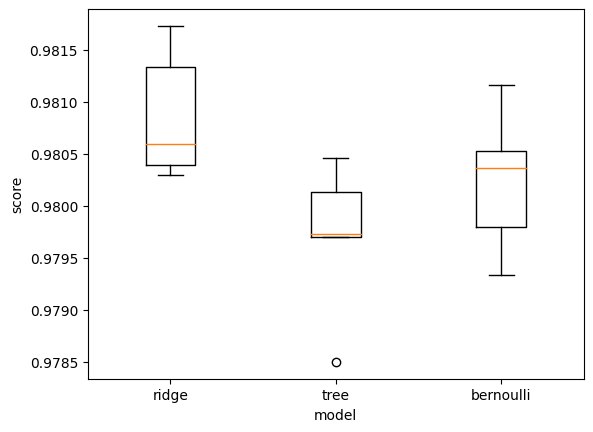

In [96]:
plt.boxplot(scores, labels=models.keys())
plt.xlabel("model")
plt.ylabel("score")
plt.title("hallo")
plt.show()

In [ ]:
results = []

# Loop through the models' values
for model in models.values():
    # Instantiate a KFold object
    kf = KFold(n_splits=10, random_state=12, shuffle=True)

    # Perform cross-validation
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_results)

results

### Decision Trees

In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier


In [79]:
# We define a simple function to determine the model score
def get_model_score(model, X, y, **kwargs):
    clf = model(**kwargs)
    clf.fit(X, y)
    return clf.score(X, y)

In [80]:
dt_params = {
    "max_depth":5,
    "random_state":42
}
dt = DecisionTreeClassifier(**dt_params)
# dt.fit(X_train, y_train)
# dt.score(X_test, y_test)
get_model_score(DecisionTreeClassifier, X_train, y_train, **dt_params)

0.9810191142253305

In [55]:
confusion_matrix(y_test, dt.predict(X_test))


array([[47174,   512,     0,     0],
       [  399,  1877,     0,     0],
       [   13,    20,     0,     0],
       [    3,     0,     0,     0]], dtype=int64)

In [67]:
dt_cvs = cross_val_score(DecisionTreeClassifier(**dt_params), X_train, y_train, cv=3)
dt_cvs.mean()

0.9807924338228138

In [51]:
et = ExtraTreeClassifier(
)
et.fit(X_train, y_train)
et.score(X_test, y_test)

0.98016

In [53]:
confusion_matrix(y_test, et.predict(X_test))

array([[23534,   266,     1],
       [  209,   970,     0],
       [    8,    12,     0]], dtype=int64)

### Ridge Classification

In [83]:
# test ridge classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
ridge = RidgeClassifier(
    # class_weight="balanced"
)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)


0.98128

In [55]:
confusion_matrix(y_test, ridge.predict(X_test))

array([[23540,   261,     0],
       [  187,   992,     0],
       [    7,    13,     0]], dtype=int64)

In [63]:
ridge_cv = RidgeClassifier()
ridge_cv.fit(X_train, y_train)
ridge_cv.score(X_test, y_test)

0.98128

In [64]:
confusion_matrix(y_test, ridge_cv.predict(X_test))

array([[23540,   261,     0],
       [  187,   992,     0],
       [    7,    13,     0]], dtype=int64)

### BernoulliNB

In [60]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb.score(X_test, y_test)

0.98112

In [58]:
confusion_matrix(y_test, bnb.predict(X_test))

array([[23536,   265,     0],
       [  187,   992,     0],
       [    7,    13,     0]], dtype=int64)

### GaussianNB

In [61]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.06896

In [62]:
confusion_matrix(y_test, gnb.predict(X_test))

array([[ 1578,  4621, 14394,  3208],
       [   21,   135,   803,   220],
       [    0,     2,    11,     7],
       [    0,     0,     0,     0]], dtype=int64)

### Random Forest

In [66]:
# test random tree classifier
from sklearn.ensemble import RandomForestClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier
rf = RandomForestClassifier(
    # n_estimators=10
    )
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9802

In [67]:
confusion_matrix(y_test, rf.predict(X_test))

array([[23524,   276,     1],
       [  198,   981,     0],
       [    7,    13,     0]], dtype=int64)

In [268]:
from sklearn.neighbors import KNeighborsClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier
clf_knn = KNeighborsClassifier(algorithm="ball_tree")
clf_knn = clf_knn.fit(X_train, y_train)
clf_knn.score(X_test, y_test)

### Gradient Boosting

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
gb = GradientBoostingClassifier(
    # n_estimators=10, 
    # learning_rate=0.0,
    # max_depth=1,
    # random_state=0
)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.98076

In [41]:
confusion_matrix(y_test, gb.predict(X_test))

array([[23538,   260,     0,     3],
       [  185,   981,     0,    13],
       [    7,    12,     0,     1],
       [    0,     0,     0,     0]], dtype=int64)

### Hyperparameter Boosting

In [98]:
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits=5, random_state=12, shuffle=True)

params = [
    {'alpha':[0.01, 0.1, 0.2, 0.5, 0.7, 1, 2]}
]

ridge_cv = GridSearchCV(RidgeClassifier(), params, cv=kf)

ridge_cv.fit(X_train, y_train)
ridge_cv.cv_results_

{'mean_fit_time': array([0.09684153, 0.09602752, 0.09923382, 0.0963675 , 0.09473748,
        0.09976053, 0.09668889]),
 'std_fit_time': array([0.00382012, 0.00282505, 0.00396796, 0.00226315, 0.00182117,
        0.005048  , 0.00344464]),
 'mean_score_time': array([0.00882449, 0.01079803, 0.00871587, 0.00881553, 0.0088366 ,
        0.00933576, 0.00928187]),
 'std_score_time': array([0.00038929, 0.0022262 , 0.00041435, 0.00036994, 0.00075671,
        0.00097498, 0.00080447]),
 'param_alpha': masked_array(data=[0.01, 0.1, 0.2, 0.5, 0.7, 1, 2],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 0.2},
  {'alpha': 0.5},
  {'alpha': 0.7},
  {'alpha': 1},
  {'alpha': 2}],
 'split0_test_score': array([0.9828    , 0.98286667, 0.98286667, 0.98286667, 0.98286667,
        0.98293333, 0.98293333]),
 'split1_test_score': array([0.9824, 0.9824, 0.9824, 0.9824, 0.9824, 0.9824

In [99]:
ridge_cv.best_params_

{'alpha': 1}

## Visualisation

In [71]:
# https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/preprocessing-and-pipelines-4?ex=14
# # Create models dictionary
models = {
    "Ridge": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    # "Random Forest": RandomForestClassifier()
    'Bernoulli NB': BernoulliNB()
}
results = []

# Loop through the models' values
for model in models.values():
    # Instantiate a KFold object
    kf = KFold(n_splits=10, random_state=12, shuffle=True)

    # Perform cross-validation
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_results)

results

[array([0.98186667, 0.984     , 0.98173333, 0.98306667, 0.98293333,
        0.98053333, 0.98066667, 0.9804    , 0.98373333, 0.98173333]),
 array([0.98106667, 0.9812    , 0.97986667, 0.9816    , 0.98213333,
        0.97826667, 0.97853333, 0.97813333, 0.9824    , 0.98      ]),
 array([0.98146667, 0.9828    , 0.98133333, 0.98266667, 0.98133333,
        0.97933333, 0.97986667, 0.97986667, 0.984     , 0.98053333])]

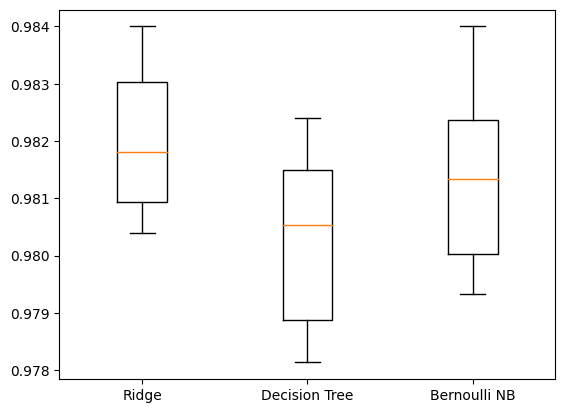

In [72]:
plt.boxplot(results, labels=models.keys())
plt.show()

### Ensemble methods

In [77]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(estimator=RidgeClassifier(), algorithm="SAMME", n_estimators=100)
abc.fit(X_train, y_train)
abc.score(X_test, y_test)

0.97872

In [78]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
bc.fit(X_train, y_train)
bc.score(X_test, y_test)

0.97988

In [80]:
from sklearn.ensemble import VotingClassifier
estimators = [
    ('ridge', RidgeClassifier()),
    ('bernoulli', BernoulliNB()), 
    ('tree', DecisionTreeClassifier())
]

vc = VotingClassifier(estimators=estimators, voting="hard")
vc.fit(X_train, y_train)
vc.score(X_test, y_test)

0.98128

In [81]:
confusion_matrix(y_test, vc.predict(X_test))

array([[23541,   260,     0],
       [  188,   991,     0],
       [    7,    13,     0]], dtype=int64)

In [39]:
from sklearn.pipeline import make_pipeline, Pipeline

pipe = make_pipeline([clf_ridge, clf_rfc, clf_dct])
# pipe.fit(X_train, y_train)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '[RidgeClassifier(), RandomForestClassifier(n_estimators=10), DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9,
                       random_state=500)]' (type <class 'list'>) doesn't

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# # Prepare the list of tuples with the first-layer classifiers


clf_ridge = RidgeClassifier()
clf_rfc = RandomForestClassifier(n_estimators=10)
clf_dct = DecisionTreeClassifier(
    min_samples_leaf=3, min_samples_split=9, random_state=500
)

classifiers = [clf_ridge, clf_rfc, clf_dct]

estimators = [
    # ('ridge', RidgeClassifier()),
    ("random_forest", RandomForestClassifier(n_estimators=10)),
    (
        "decision_tree",
        DecisionTreeClassifier(
            min_samples_leaf=3, min_samples_split=9, random_state=500
        ),
    ),
]

# Instantiate the second-layer meta estimator
clf_meta = LogisticRegression()
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

# Build the stacking classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn-ensemble-stackingclassifier
clf_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=clf_meta,
    # stack_method='predict_proba',
    passthrough=False,
)


clf_stack.fit(X_train, y_train)
clf_stack.score(X_test, y_test)

c:\Users\hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (12) does not match total number of classes (13). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (12) does not match total number of classes (13). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\hauke\AppData\Local\Progr

0.71872

In [28]:
zip(*classifiers)

TypeError: 'RidgeClassifier' object is not iterable

In [ ]:
clf_rfc.get_params()

## Roads

In [ ]:
# data["on_street_name"].str.split(" ")

## Cyclists

### Injured Cyclists

In [ ]:
data["number_of_cyclist_injured"].value_counts(dropna=True)
# data.head(10)

### Contributing factors